In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.io import loadmat
import h5py
from matplotlib.animation import FuncAnimation
from matplotlib import cm

def compute_fourier_transform_and_wave_numbers(psi, K):

    # Compute the Fourier transform
    psi_hat = np.fft.fft2(psi,[K,K])
    
    # Generate wave numbers for each dimension
    kx = np.fft.fftfreq(K) * K
    ky = np.fft.fftfreq(K) * K
    kk = np.meshgrid(kx, ky)#, indexing='ij') the indexing should agree with the real space meshgrid indexing 
    
    return psi, psi_hat, kk

def verify_conjugate_symmetry(Y):
    """
    Checks if the matrix Y is conjugate symmetric based on the given conditions.
    
    Parameters:
    - Y: np.ndarray, a numpy array representing the matrix.
    
    Returns:
    - bool, True if the matrix Y is conjugate symmetric, False otherwise.
    """
    # Condition 1: Check if Y[0, 1:] is conjugate symmetric
    condition1 = np.allclose(Y[0, 1:], np.conj(Y[0, -1:0:-1]))
    
    # Condition 2: Check if Y[1:, 0] is conjugate symmetric
    condition2 = np.allclose(Y[1:, 0], np.conj(Y[-1:0:-1, 0]))
    
    # Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
    condition3 = np.allclose(Y[1:, 1:], np.conj(Y[-1:0:-1, -1:0:-1]))
    
    # Return True if all conditions are met, False otherwise
    return condition1 and condition2 and condition3

def flatten_matrix_and_wave_numbers(psi_hat, kk):
    # Flatten the matrices
    psi_hat_flat = psi_hat.flatten()
    kk_flat = np.array(kk).reshape(2, -1)
    return psi_hat_flat, kk_flat

np.random.seed(2024)

In [2]:
class Lagrange_tracer_model:
    """
    math of the model:
    v(x, t) =\sum_k{psi_hat_{1,k}(t) e^(ik·x) r_k}
    r_k=(ik_2,-ik_1). 

    """
    def __init__(self, N, L, kx, ky, psi_hat, dt, sigma_xy, x0, y0, interv=1, t_interv=100):
        """
        Parameters:
        - N: int, total number of steps
        - L: int, number of tracers
        - kx: np.array of shape (K,), wave numbers of x direction. K is the number of 1D Fourier modes.
        - ky: np.array of shape (K,), wave numbers of y direction. K is the number of 1D Fourier modes.
        - psi_hat: np.array of shape (N, K, K), Fourier time series of the upper layer stream function.
        - dt: float, time step
        - sigma_xy: float, standard deviation of the noise
        - x0:  Initial tracer locations in x of shape (L, 1)
        - y0:  Initial tracer locations in y of shape (L, 1)
        - interv:  int, wave number inverval for calculating u, v field 
        - t_interv: int, time interval for calculate and save u, v field
        """
        self.N = N
        self.L = L
        self.K = kx.shape[0]
        self.kx, self.ky = np.meshgrid(kx, ky)
        self.psi_hat = psi_hat
        self.dt = dt
        self.sigma_xy = sigma_xy
        self.x = np.zeros((L, N))  
        self.y = np.zeros((L, N))
        self.xgrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
        self.ygrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
        self.ut = np.zeros((self.K//interv, self.K//interv, N//t_interv))  
        self.vt = np.zeros((self.K//interv, self.K//interv, N//t_interv))
        self.x[:,0] = x0
        self.y[:,0] = y0
        self.interv = interv
        self.t_interv = t_interv

    def forward(self):
        """
        Integrates tracer locations using forward Euler method.
        
        There are to ways to get u,v from psi_hat.
        1) write the modified Fourier coefficients as psi_hat_{1,k} r_k, do ifft2. Then interpolate velocity on the grid points to (x,y).
        2) use (x,y) when computing the exponential components, then manually sum up. But this may bring imaginary parts to the results.
        
        """
        l = 0
        for i in range(1, self.N):
            exp_term = np.exp(1j * self.x[:, i-1][:,None] @ self.kx.flatten()[None,:] + 1j * self.y[:, i-1][:,None] @ self.ky.flatten()[None,:])
            uk = (self.psi_hat[:, :, i-1] * (1j) * self.ky)
            vk = (self.psi_hat[:, :, i-1] * (-1j) * self.kx)
            uk[self.K//2, :] = 0; uk[:, self.K//2] = 0; vk[self.K//2, :] = 0; vk[:, self.K//2] = 0 # ensure conjugate symmetric
#             print('verify_conjugate_symmetry', [verify_conjugate_symmetry(uk),verify_conjugate_symmetry(vk)])
            u = np.squeeze(exp_term @ uk.flatten()[:,None]) / self.K**2
            v = np.squeeze(exp_term @ vk.flatten()[:,None]) / self.K**2
            max_imag_abs = max(np.max(np.abs(np.imag(u))), np.max(np.abs(np.imag(v))))
            if max_imag_abs > 1e-10:
                raise Exception("get significant imaginary parts, check the ifft2")
            else:
                u = np.real(u)
                v = np.real(v)
                
            self.x[:, i] = self.x[:, i-1] + u * self.dt + np.random.randn(self.L) * self.sigma_xy * np.sqrt(self.dt)
            self.y[:, i] = self.y[:, i-1] + v * self.dt + np.random.randn(self.L) * self.sigma_xy * np.sqrt(self.dt)
            self.x[:, i] = np.mod(self.x[:, i] + np.pi, 2*np.pi) - np.pi  # Periodic boundary conditions
            self.y[:, i] = np.mod(self.y[:, i] + np.pi, 2*np.pi) - np.pi  # Periodic boundary conditions

            if np.mod(i,self.t_interv) == 0:
#                 # manually do ifft2
#                 for jx in range(0,self.K,self.interv):
#                     for jy in range(0,self.K,self.interv):
#                         exp_term = np.exp(1j * self.xgrid[jx] * self.kx.flatten()[None,:] + 1j * self.ygrid[jy] * self.ky.flatten()[None,:])
#                         uk = (self.psi_hat[:, :, i-1] * (1j) * self.ky)
#                         vk = (self.psi_hat[:, :, i-1] * (-1j) * self.kx)
#                         uk[self.K//2, :] = 0; uk[:, self.K//2] = 0; vk[self.K//2, :] = 0; vk[:, self.K//2] = 0 # ensure conjugate symmetric
#                         u = np.squeeze(exp_term @ uk.flatten()[:,None]) / self.K**2
#                         v = np.squeeze(exp_term @ vk.flatten()[:,None]) / self.K**2
#                         max_imag_abs = max(np.max(np.abs(np.imag(u))), np.max(np.abs(np.imag(v))))
#                         if max_imag_abs > 1e-10:
#                             raise Exception("get significant imaginary parts, check the ifft2")
#                         else:
#                             u = np.real(u)
#                             v = np.real(v)

#                         self.ut[jy//self.interv,jx//self.interv,l] = u
#                         self.vt[jy//self.interv,jx//self.interv,l] = v
                     
                # using built-in ifft2
                u_ifft = np.fft.ifft2(self.psi_hat[:, :, i-1] * 1j * self.ky)
                u_ifft_shift = np.roll(u_ifft, shift=self.K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
                u_ifft_shift = np.roll(u_ifft_shift, shift=self.K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
                self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
                v_ifft = np.fft.ifft2(self.psi_hat[:, :, i-1] * (-1j) * self.kx)
                v_ifft_shift = np.roll(v_ifft, shift=self.K//2, axis=0) # shift domain from [0,2pi) to [-pi,pi)
                v_ifft_shift = np.roll(v_ifft_shift, shift=self.K//2, axis=1) # shift domain from [0,2pi) to [-pi,pi)
                self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
                        
                l += 1

        return self.x, self.y, self.ut, self.vt

In [3]:
# # load data
data_path = '/Users/ree/Documents/Research/Proj_1_LangrangeDA/code/qg_2layer_topo/QG_DATA_topo025_0219.mat'
with h5py.File(data_path, 'r') as file:
#     print("Keys: %s" % file.keys())
    psi_hat_t = np.transpose(file['psi_1_t'][()], axes=(2, 1, 0)) # reorder the dimensions from Python's row-major order back to MATLAB's column-major order 
    dt = file['dt'][()][0,0]
    params_dataset = file['params']
    topo = params_dataset['H'][()] [0,0]
    u1_t = np.transpose(file['u1_t'][()], axes=(2, 1, 0))
    v1_t = np.transpose(file['v1_t'][()], axes=(2, 1, 0))
print('psi_hat_t.shape',psi_hat_t.shape)
psi_hat_t = psi_hat_t['real'] + 1j * psi_hat_t['imag']
print('psi_hat_t.dtype',psi_hat_t.dtype)
print('u1_t.shape',u1_t.shape)

psi_hat_t.shape (256, 256, 5000)
psi_hat_t.dtype complex128
u1_t.shape (256, 256, 50)


In [4]:
# Generate wave numbers for each dimension
L = 1
K = psi_hat_t.shape[0]
N = psi_hat_t.shape[2]
kx = np.fft.fftfreq(K) * K
ky = np.fft.fftfreq(K) * K
# kx[K//2] = -kx[K//2]
# ky[K//2] = -ky[K//2]
sigma_xy = 0.1
x0 = np.random.uniform(-np.pi, np.pi, L)
y0 = np.random.uniform(-np.pi, np.pi, L)
print('initial (x0,y0):',[x0,y0])

initial (x0,y0): [array([0.55301153]), array([1.25103716])]


In [5]:
# run model
model = Lagrange_tracer_model(N, L, kx, ky, psi_hat_t, dt, sigma_xy, x0, y0, interv=8)
xt, yt, ut, vt = model.forward()   

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_11616/1842880472.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[:,:,l] = u_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids
/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_11616/1842880472.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  self.vt[:,:,l] = v_ifft_shift[::self.interv, ::self.interv] # only save the sparsely sampled grids


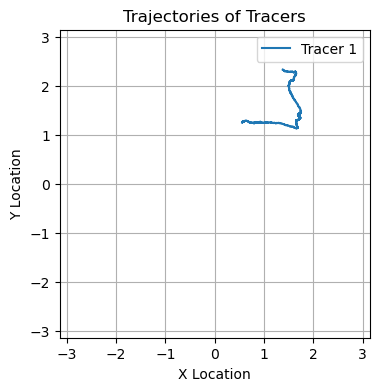

In [6]:
# plot trajectories
plt.figure(figsize=(4, 4))
for i in range(L):  # Loop over the tracers
    plt.plot(xt[i], yt[i], label=f'Tracer {i+1}')
plt.xlim([-np.pi,np.pi])
plt.ylim([-np.pi,np.pi])
plt.title('Trajectories of Tracers')
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.legend()
plt.grid(True)
plt.show()

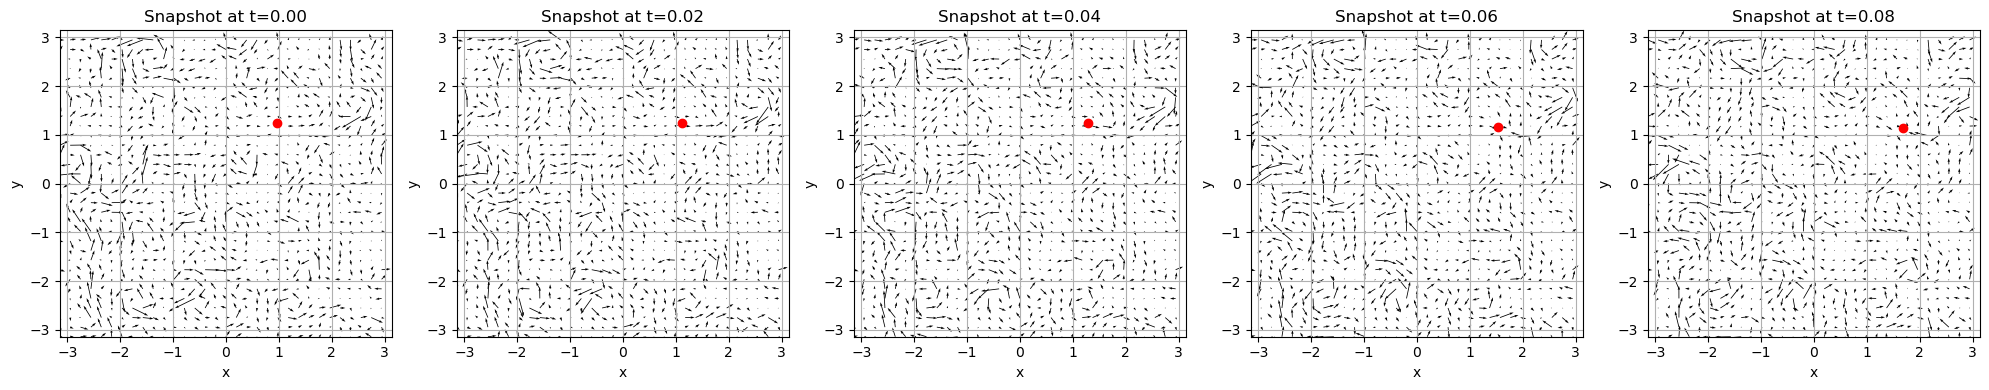

In [26]:
# snapshots of tracers on flow field
x_interv = 200
v_interv = 2
numfigs = 5
x_begin = 1000
v_begin = 10
tracer_x = xt[0,x_begin:x_begin+numfigs*x_interv:x_interv]
tracer_y = yt[0,x_begin:x_begin+numfigs*x_interv:x_interv]
velocity_ut = ut[:,:,v_begin:v_begin+numfigs*v_interv:v_interv]
velocity_vt = vt[:,:,v_begin:v_begin+numfigs*v_interv:v_interv]

# Now plot the snapshots of the velocity field and the tracer location.
fig, axs = plt.subplots(1, numfigs, figsize=(20, 4))
interv = 8
for i in range(numfigs):
    # Create a grid of arrow locations
    xgrid = np.linspace(-np.pi, np.pi, int(K/interv), endpoint=False)
    ygrid = np.linspace(-np.pi, np.pi, int(K/interv), endpoint=False)
    X, Y = np.meshgrid(xgrid, ygrid)
    axs[i].quiver(X, Y, velocity_ut[:,:,i], velocity_vt[:,:,i])
    axs[i].plot(tracer_x[i], tracer_y[i], 'ro')  # 'ro' is the matplotlib code for a red circle
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_ylim([-np.pi, np.pi])
    axs[i].set_title(f'Snapshot at t={i*x_interv*dt:.2f}')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].grid(True)

plt.tight_layout()
plt.savefig('tracer_flowfield.png', dpi=100)
plt.show()

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_11616/786306084.py:26: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  tracer.set_data(tracer_x[frame], tracer_y[frame])


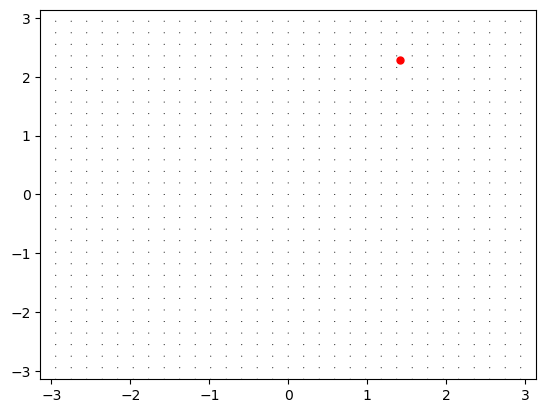

In [8]:
# animation of tracers on flow field
tracer_x = xt[0,::100]
tracer_y = yt[0,::100]
velocity_ut = ut
velocity_vt = vt

# Set up the figure and axis for plotting
fig, ax = plt.subplots()
interv = 8
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-np.pi, np.pi])
xgrid = np.linspace(-np.pi, np.pi, int(K/interv), endpoint=False)
ygrid = np.linspace(-np.pi, np.pi, int(K/interv), endpoint=False)
X, Y = np.meshgrid(xgrid, ygrid)
quiver = ax.quiver(X, Y, velocity_ut[:,:,0], velocity_vt[:,:,0])#, color='lightgrey', scale=10)
tracer, = ax.plot([], [], 'ro', markersize=5)  # Initial empty tracer plot

# Initialization function for FuncAnimation
def init():
    tracer.set_data([], [])
    quiver.set_UVC(velocity_ut[:,:,0], velocity_vt[:,:,0])
    return tracer, quiver

# Update function for FuncAnimation
def update(frame):
    tracer.set_data(tracer_x[frame], tracer_y[frame])
    quiver.set_UVC(velocity_ut[:,:,frame], velocity_vt[:,:,frame])
    return tracer, quiver

# Create animation
ani = FuncAnimation(fig, update, frames=range(50), init_func=init, blit=False, interval=400)

# Save the animation
ani.save('tracer_flow_animation.gif', writer='pillow', dpi=80)

plt.show()

# Go through the Inverse Fourier Transform mannually to clarify every detail

## Idealy, if $d\psi/dx$ has a closed form, the Fourier coefficient of $d\psi/dx$,$v_k$ , should be conjugate symmetric and $v$ should be real value. 

verify_conjugate_symmetry: True
[ 3.11919183e-14+3.94643816e-16j -1.13444717e-15-2.40157032e-15j
 -6.19542749e-16+1.70341185e-16j]
[ 3.11919183e-14-3.94643816e-16j -1.13444717e-15+2.40157032e-15j
 -6.19542749e-16-1.70341185e-16j]
(-2.5257204217389185e-14+1.9962827691558777e-12j)
(2.5257204217389226e-14+1.996282769155878e-12j)


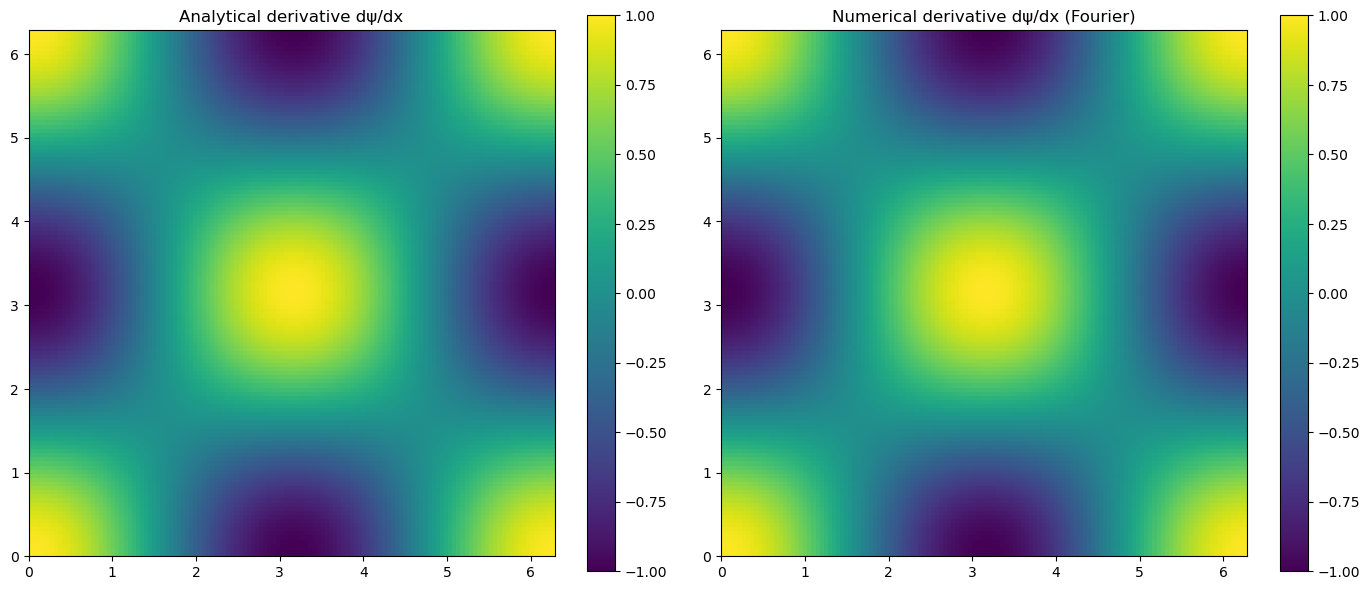

Max difference between analytical and numerical derivatives: 1.8096635301390052e-14


In [195]:
import numpy as np
import matplotlib.pyplot as plt

# Define a grid and a sample stream function in the spatial domain
K = 128
x = np.linspace(0, 2*np.pi, K, endpoint=False)
y = np.linspace(0, 2*np.pi, K, endpoint=False)
X, Y = np.meshgrid(x, y)

# Define a stream function ψ = sin(x)cos(y)
psi = np.sin(X) * np.cos(Y)
# psi = np.sin(X) * np.cos(Y) + np.random.randn(K,K) * 1e-3 # if psi is not smooth enough to derivate, vk will not be conjugate symmetric

# Compute the analytical derivative with respect to x: dψ/dx = cos(x)cos(y)
v_analytical = np.cos(X) * np.cos(Y)

# Compute the Fourier transform of ψ
psi_k = np.fft.fft2(psi)

# Generate wavevector indices for kx and ky
kx = np.fft.fftfreq(psi.shape[0], d=(x[1]-x[0])/(2*np.pi))
ky = np.fft.fftfreq(psi.shape[1], d=(y[1]-y[0])/(2*np.pi))
# kx[K//2] = -kx[K//2]
# ky[K//2] = -ky[K//2]
kx, ky = np.meshgrid(kx, ky)

# Compute the Fourier transform of the derivative of ψ with respect to x using the relation i*kx*ψ_k
v_k = 1j * kx * psi_k
print('verify_conjugate_symmetry:', verify_conjugate_symmetry(v_k))

# verify that K/2 column and line should be zero
print(psi_k[1:,1:][:3,K//2-1])
print(psi_k[-1:0:-1, -1:0:-1][:3,K//2-1])
e1 = psi_k[1:,1:][0,K//2-1]
e2 = psi_k[-1:0:-1, -1:0:-1][0,K//2-1]
print(e1 * 1j*kx[:,K//2][0])
print(e2 * 1j*kx[:,K//2][0])

# Convert v_k back to the spatial domain using the inverse FFT
v_numerical = np.fft.ifft2(v_k)
max_imag_abs = np.max(np.abs(np.imag(v_numerical)))
if max_imag_abs > 1e-10:
    raise Exception("get significant imaginary parts, check the ifft2") 
else:
    v_numerical = v_numerical.real

# Plot the analytical and numerical derivatives for comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(v_analytical, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower')
plt.colorbar()
plt.title('Analytical derivative dψ/dx')

plt.subplot(1, 2, 2)
plt.imshow(v_numerical, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower')
plt.colorbar()
plt.title('Numerical derivative dψ/dx (Fourier)')

plt.tight_layout()
plt.show()

# Compare the analytical and numerical derivatives to validate the relationship
difference = np.abs(v_analytical - v_numerical)
print(f"Max difference between analytical and numerical derivatives: {np.max(difference)}")


In [349]:
# try interpolate
from scipy import interpolate

L=1
k = 46.2
x = np.ones(L)*np.pi*2*k/K
y = np.ones(L)*np.pi*2*k/K
exp_term = np.exp(1j * x[:,None] @ kx.flatten()[None,:] + 1j * y[:,None] @ ky.flatten()[None,:])
v = np.squeeze(exp_term @ (psi_k.flatten() * 1j * kx.flatten())[:,None]) / K**2
print(v,v_analytical[round(k-0.5),round(k-0.5)],v_numerical[round(k-0.5),round(k-0.5)])
print(v,v_analytical[round(k+0.5),round(k+0.5)],v_numerical[round(k+0.5),round(k+0.5)])

# Interpolate the velocity field at tracer positions
v_interp = (v_numerical[round(k-0.5),round(k-0.5)]+v_numerical[round(k-0.5),round(k+0.5)]++v_numerical[round(k+0.5),round(k-0.5)]+v_numerical[round(k+0.5),round(k+0.5)])/4
print(v_interp)

(0.4121018600328231+1.992256922128263e-17j) 0.40245483899193574 0.4024548389919334
(0.4121018600328231+1.992256922128263e-17j) 0.4509914298352197 0.4509914298352188
0.4263778126442418


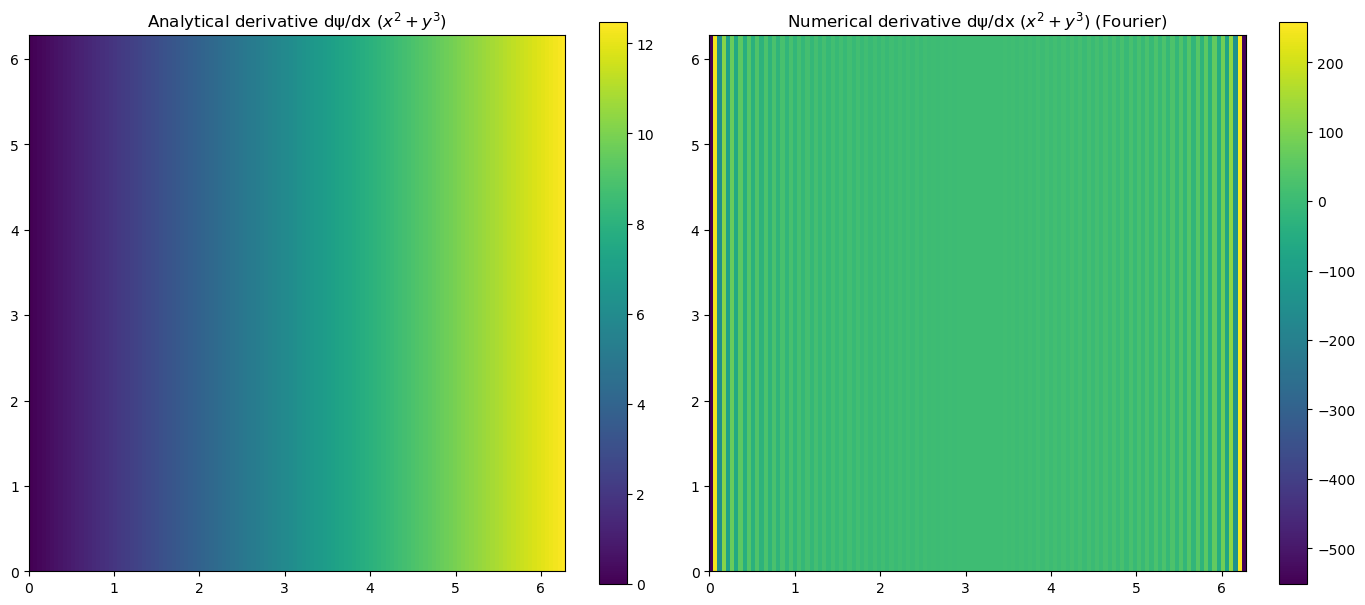

Max difference between analytical and numerical derivatives: 554.9951389298257


In [303]:
# Redefine the stream function ψ = x^2 + y^3 and its analytical derivative with respect to x: dψ/dx = 2x
psi = X**2 + Y**3
v_analytical = 2*X

# Compute the Fourier transform of ψ
psi_k = np.fft.fft2(psi)

# Compute the Fourier transform of the derivative of ψ with respect to x using the relation i*kx*ψ_k
v_k = 1j * kx * psi_k

# Convert v_k back to the spatial domain using the inverse FFT
v_numerical = np.fft.ifft2(v_k).real

# Plot the analytical and numerical derivatives for comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(v_analytical, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower')
plt.colorbar()
plt.title('Analytical derivative dψ/dx ($x^2 + y^3$)')

plt.subplot(1, 2, 2)
plt.imshow(v_numerical, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower')
plt.colorbar()
plt.title('Numerical derivative dψ/dx ($x^2 + y^3$) (Fourier)')

plt.tight_layout()
plt.show()

# Compare the analytical and numerical derivatives to validate the relationship
difference = np.abs(v_analytical - v_numerical)
print(f"Max difference between analytical and numerical derivatives: {np.max(difference)}")


After changing the stream function to $\psi = x^2 + y^3$, and computing both the analytical and numerical derivatives with respect to $x$, we observe a significant difference between the two methods. This discrepancy arises not because the Fourier method is incorrect, but due to the inherent periodicity assumed by the Fourier transform, which may not align well with the non-periodic nature of the function $x^2 + y^3$ over the domain $[0, 2\pi] \times [0, 2\pi]$.


## now back to our Tracer model case

In [198]:
verify_conjugate_symmetry(psi_hat_t[0,:,:])

True

In [199]:
testmat = psi_hat_t[0,:,:] * 1j * kxx
# Condition 1: Check if Y[0, 1:] is conjugate symmetric
condition1 = np.allclose(testmat[0, 1:], np.conj(testmat[0, -1:0:-1]))
print(condition1)
# Condition 2: Check if Y[1:, 0] is conjugate symmetric
condition2 = np.allclose(testmat[1:, 0], np.conj(testmat[-1:0:-1, 0]))
print(condition2)
# Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
condition3 = np.allclose(testmat[1:, 1:], np.conj(testmat[-1:0:-1, -1:0:-1]))
print(condition3)

verify_conjugate_symmetry(psi_hat_t[0,:,:] * 1j * kxx)

False
True
False


False

In [200]:
testmat[K//2, K//2]

0.0008115364929433039j

In [201]:
testmat[K//2, :] = 0; testmat[:, K//2] = 0
condition1 = np.allclose(testmat[0, 1:], np.conj(testmat[0, -1:0:-1]))
print(condition1)
# Condition 2: Check if Y[1:, 0] is conjugate symmetric
condition2 = np.allclose(testmat[1:, 0], np.conj(testmat[-1:0:-1, 0]))
print(condition2)
# Condition 3: Check if Y[1:, 1:] is conjugate centrosymmetric
condition3 = np.allclose(testmat[1:, 1:], np.conj(testmat[-1:0:-1, -1:0:-1]))
print(condition3)

True
True
True


In [202]:
array1 = testmat[1:, 1:]
array2 = np.conj(testmat[-1:0:-1, -1:0:-1])
differences = array1 - array2
different_indices = np.where(np.logical_or(np.abs(differences.real) > 1e-10, np.abs(differences.imag) > 1e-10))
different_indices

(array([], dtype=int64), array([], dtype=int64))

In [174]:
testmat[1:, 1:][:3,127]

array([7.71606861-12.97280624j, 3.52965873+15.22524933j,
       1.55696116 +0.66820433j])

In [175]:
testmat[-1:0:-1, -1:0:-1][:3,127]

array([-7.71606861-12.97280624j, -3.52965873+15.22524933j,
       -1.55696116 +0.66820433j])

In [176]:
np.conj(testmat[-1:0:-1, -1:0:-1])[:3,127]

array([-7.71606861+12.97280624j, -3.52965873-15.22524933j,
       -1.55696116 -0.66820433j])

In [179]:
print(psi_hat_t[0,1:,1:][0,127])
print(psi_hat_t[0,-1:0:-1, -1:0:-1][0,127])

(0.1013500487446948+0.06028178601154173j)
(0.1013500487446948-0.06028178601154173j)


In [182]:
e1 = psi_hat_t[0,1:,1:][0,127]
e2 = psi_hat_t[0,-1:0:-1, -1:0:-1][0,127]
print(e1 * 1j*kxx[:,128][0])
print(e2 * 1j*kxx[:,128][0])

(7.716068609477341-12.972806239320935j)
(-7.716068609477341-12.972806239320935j)


In [183]:
import numpy as np
import matplotlib.pyplot as plt

# Define a grid and a sample stream function in the spatial domain
K = 4
x = np.linspace(0, 2*np.pi, K, endpoint=False)
y = np.linspace(0, 2*np.pi, K, endpoint=False)
X, Y = np.meshgrid(x, y)

# Define a stream function ψ = sin(x)cos(y)
psi = np.sin(X) * np.cos(Y)
# psi = np.sin(X) * np.cos(Y) + np.random.randn(K,K) * 1e-3 # if psi is not smooth enough to derivate, vk will not be conjugate symmetric

# Compute the analytical derivative with respect to x: dψ/dx = cos(x)cos(y)
v_analytical = 2* np.cos(2*X) * np.cos(Y) - np.sin(X)

# Compute the Fourier transform of ψ
psi_k = np.fft.fft2(psi)

# Generate wavevector indices for kx and ky
kx = np.fft.fftfreq(psi.shape[0], d=(x[1]-x[0])/(2*np.pi))
ky = np.fft.fftfreq(psi.shape[1], d=(y[1]-y[0])/(2*np.pi))
kx, ky = np.meshgrid(kx, ky)

# Compute the Fourier transform of the derivative of ψ with respect to x using the relation i*kx*ψ_k
v_k = 1j * kx * psi_k
print('verify_conjugate_symmetry:', verify_conjugate_symmetry(v_k))

verify_conjugate_symmetry: True


In [189]:
print(psi_k[1:,1:][0,1])
print(psi_k[-1:0:-1, -1:0:-1][0,1])
e1 = psi_k[1:,1:][0,1]
e2 = psi_k[-1:0:-1, -1:0:-1][0,1]
print(e1 * 1j*kx[:,2][0])
print(e2 * 1j*kx[:,2][0])

(2.4492935982947064e-16-2.999519565323715e-32j)
(2.4492935982947064e-16+2.999519565323715e-32j)
(-5.99903913064743e-32-4.898587196589413e-16j)
(5.99903913064743e-32-4.898587196589413e-16j)


#### $\psi$ is from a pde with random noise on the RHS, so $v_k$ will not be strictly conjugate symmetric  unless we manually set the \psi_hat (K/2,:) and \psi_hat(:,K/2) be zero

# Mismatch of the our defined real space domain [-pi,pi) and np.ifft2 default real space domain [0,2pi)

In [73]:
# Mismatch of the our defined real space domain [-pi,pi) and np.ifft2 default real space domain [0,2pi)

class test:
    """
    math of the model:
    v(x, t) =\sum_k{psi_hat_{1,k}(t) e^(ik·x) r_k}
    r_k=(ik_2,-ik_1). 

    """
    def __init__(self, N, L, kx, ky, psi_hat, dt, sigma_xy, x0, y0, interv=1):
        """
        Parameters:
        - N: int, total number of steps
        - L: int, number of tracers
        - kx: np.array of shape (K,), wave numbers of x direction. K is the number of 1D Fourier modes.
        - ky: np.array of shape (K,), wave numbers of y direction. K is the number of 1D Fourier modes.
        - psi_hat: np.array of shape (N, K, K), Fourier time series of the upper layer stream function.
        - dt: float, time step
        - sigma_xy: float, standard deviation of the noise
        - x:  Initial tracer locations in x of shape (L, 1)
        - y:  Initial tracer locations in y of shape (L, 1)
        """
        self.N = N
        self.L = L
        self.K = kx.shape[0]
        self.kx, self.ky = np.meshgrid(kx, ky)
        self.psi_hat = psi_hat
        self.dt = dt
        self.sigma_xy = sigma_xy
        self.x = np.zeros((L, N))  
        self.y = np.zeros((L, N))
        self.xgrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
        self.ygrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
#         self.xgrid = np.linspace(0,2*np.pi, self.K, endpoint=False)
#         self.ygrid = np.linspace(0,2*np.pi, self.K, endpoint=False)
        self.ut = np.zeros((self.K//interv, self.K//interv))  
        self.vt = np.zeros((self.K//interv, self.K//interv))
        self.x[:,0] = x0
        self.y[:,0] = y0
        self.interv = interv
        
    def forward(self):
        i = 1
        for jx in range(0,self.K,self.interv):
            for jy in range(0,self.K,self.interv):
                exp_term = np.exp(1j * self.xgrid[jx] * self.kx.flatten()[None,:] + 1j * self.ygrid[jy] * self.ky.flatten()[None,:])
                uk = (self.psi_hat[:, :, i-1] * 1j * self.ky)
#                 uk[self.K//2, :] = 0; uk[:, self.K//2] = 0;
                u = np.squeeze(exp_term @ uk.flatten()[:,None]) / self.K**2
#                 max_imag_abs = np.max(np.abs(np.imag(u)))
#                 if max_imag_abs > 1e-10:
#                     raise Exception("get significant imaginary parts, check the ifft2")
#                 else:
#                     u = np.real(u)
                        
                self.ut[jx//self.interv,jy//self.interv] = u
                    
        u_ifft = np.fft.ifft2(self.psi_hat[:, :, i-1] * 1j * self.ky)
        
        return self.ut, u_ifft
    
testmodel = test(N, L, kx, ky, psi_hat_t, dt, sigma_xy, x0, y0)
u_sum, uifft = testmodel.forward()
print(np.allclose(u_sum.T, np.real(uifft)))
u_sum_roll = np.roll(u_sum, shift=K//2, axis=0)
u_sum_roll = np.roll(u_sum_roll, shift=K//2, axis=1)
print(np.allclose(u_sum_roll.T, np.real(uifft)))

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_1477/4055039056.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[jx//self.interv,jy//self.interv] = u


False
True


In [ ]:
# maybe we should use [0,2pi) in mannual ifft2 and shift the domain in real space later

# reversed ordering between python and matlab

In [89]:
# after reordering the indices
class test:
    """
    math of the model:
    v(x, t) =\sum_k{psi_hat_{1,k}(t) e^(ik·x) r_k}
    r_k=(ik_2,-ik_1). 

    """
    def __init__(self, N, L, kx, ky, psi_hat, dt, sigma_xy, x0, y0, interv=1):
        """
        Parameters:
        - N: int, total number of steps
        - L: int, number of tracers
        - kx: np.array of shape (K,), wave numbers of x direction. K is the number of 1D Fourier modes.
        - ky: np.array of shape (K,), wave numbers of y direction. K is the number of 1D Fourier modes.
        - psi_hat: np.array of shape (N, K, K), Fourier time series of the upper layer stream function.
        - dt: float, time step
        - sigma_xy: float, standard deviation of the noise
        - x:  Initial tracer locations in x of shape (L, 1)
        - y:  Initial tracer locations in y of shape (L, 1)
        """
        self.N = N
        self.L = L
        self.K = kx.shape[0]
        self.kx, self.ky = np.meshgrid(kx, ky)
        self.psi_hat = psi_hat
        self.dt = dt
        self.sigma_xy = sigma_xy
        self.x = np.zeros((L, N))  
        self.y = np.zeros((L, N))
        self.xgrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
        self.ygrid = np.linspace(-np.pi,np.pi, self.K, endpoint=False)
#         self.xgrid = np.linspace(0,2*np.pi, self.K, endpoint=False)
#         self.ygrid = np.linspace(0,2*np.pi, self.K, endpoint=False)
        self.ut = np.zeros((self.K//interv, self.K//interv))  
        self.vt = np.zeros((self.K//interv, self.K//interv))
        self.x[:,0] = x0
        self.y[:,0] = y0
        self.interv = interv
        
    def forward(self):
        i = 1
        for jx in range(0,self.K,self.interv):
            for jy in range(0,self.K,self.interv):
                exp_term = np.exp(1j * self.xgrid[jx] * self.kx.flatten()[None,:] + 1j * self.ygrid[jy] * self.ky.flatten()[None,:])
                uk = (self.psi_hat[:, :, i-1] * 1j * self.ky)
#                 uk[self.K//2, :] = 0; uk[:, self.K//2] = 0;
                u = np.squeeze(exp_term @ uk.flatten()[:,None]) / self.K**2
#                 max_imag_abs = np.max(np.abs(np.imag(u)))
#                 if max_imag_abs > 1e-10:
#                     raise Exception("get significant imaginary parts, check the ifft2")
#                 else:
#                     u = np.real(u)
                        
                self.ut[jy//self.interv,jx//self.interv] = u
              
#         self.ky[self.K//2,:] = -self.ky[self.K//2,:]
        u_ifft = np.fft.ifft2(self.psi_hat[:, :, i-1] * 1j * self.ky)
        
        return self.ut, u_ifft

testmodel = test(N, L, kx, ky, psi_hat_t[:,:,99::100], dt, sigma_xy, x0, y0)
u_sum, uifft = testmodel.forward()

/var/folders/lz/50081q0n24g8lq6ncqpbp8780000gn/T/ipykernel_1477/3678964388.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  self.ut[jy//self.interv,jx//self.interv] = u


In [90]:
print(np.allclose(u1_t[:,:,0], np.real(uifft)))

True


In [91]:
u_sum_roll = np.roll(u_sum, shift=K//2, axis=0)
u_sum_roll = np.roll(u_sum_roll, shift=K//2, axis=1)
print(np.allclose(u_sum_roll, np.real(uifft)))

True


In [94]:
u_ifft_roll = np.roll(uifft, shift=K//2, axis=0)
u_ifft_roll = np.roll(u_ifft_roll, shift=K//2, axis=1)
print(np.allclose(u_sum, np.real(u_ifft_roll)))

True


## now we can safely say that 
1. the manually summation is correctly align with built-in ifft2 function
2. the resulting u,v aligns with matlab code

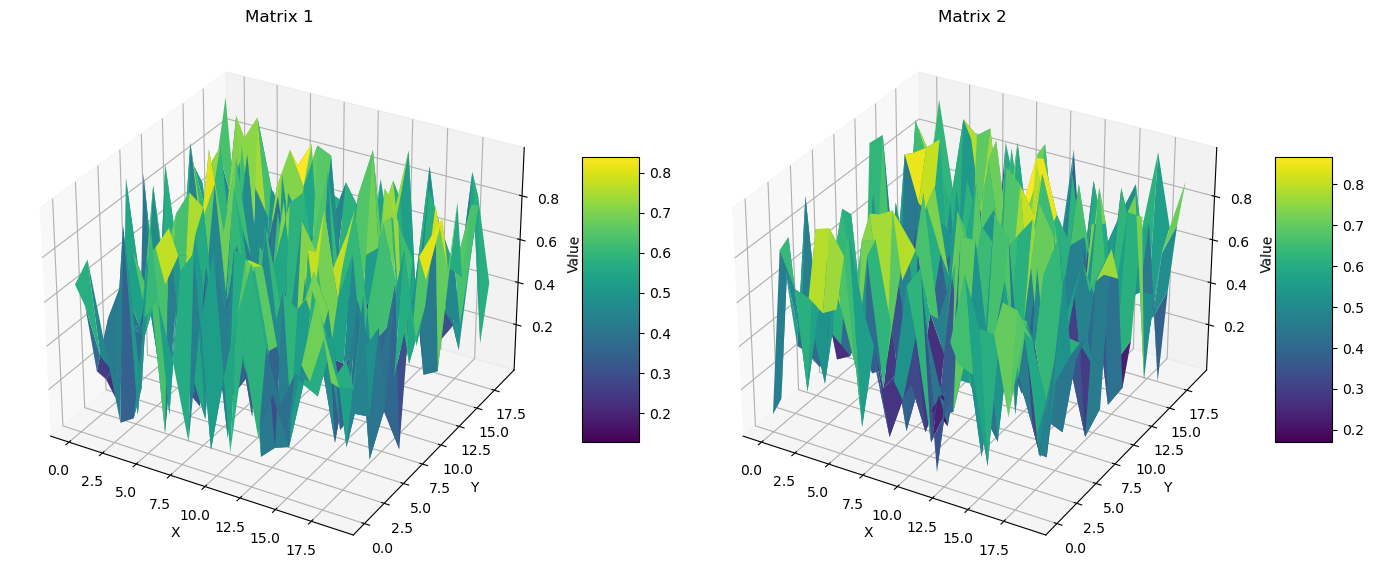

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming matrix1 and matrix2 are your two matrices of shape [K, K]
# For demonstration, let's create two sample matrices
K = 20
matrix1 = np.random.rand(K, K)  # Generate a random matrix
matrix2 = np.random.rand(K, K)  # Generate another random matrix

# Generate grid indices for the KxK matrices
x = np.linspace(0, K-1, K)
y = np.linspace(0, K-1, K)
x, y = np.meshgrid(x, y)

# Create a figure for the plots
fig = plt.figure(figsize=(14, 6))

# Plot for matrix1
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, 1st subplot
surf1 = ax1.plot_surface(x, y, matrix1, cmap='viridis', edgecolor='none')
ax1.set_title('Matrix 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Value')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot for matrix2
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, 2nd subplot
surf2 = ax2.plot_surface(x, y, matrix2, cmap='viridis', edgecolor='none')
ax2.set_title('Matrix 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Value')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
a = 4 * np.eye(4)
a[0,2] += 3
np.fft.ifft2(a)


array([[ 1.1875+0.j, -0.1875+0.j,  0.1875+0.j, -0.1875+0.j],
       [ 0.1875+0.j, -0.1875+0.j,  0.1875+0.j,  0.8125+0.j],
       [ 0.1875+0.j, -0.1875+0.j,  1.1875+0.j, -0.1875+0.j],
       [ 0.1875+0.j,  0.8125+0.j,  0.1875+0.j, -0.1875+0.j]])

In [6]:
np.fft.ifft2(a.T)

array([[ 1.1875+0.j,  0.1875+0.j,  0.1875+0.j,  0.1875+0.j],
       [-0.1875+0.j, -0.1875+0.j, -0.1875+0.j,  0.8125+0.j],
       [ 0.1875+0.j,  0.1875+0.j,  1.1875+0.j,  0.1875+0.j],
       [-0.1875+0.j,  0.8125+0.j, -0.1875+0.j, -0.1875+0.j]])